In [ ]:
#colab notebook myDrive 연동용 코드

import os, sys
from google.colab import drive
drive.mount('/content/drive')

# my_path = '/content/notebooks'
# os.symlink('/content/drive/MyDrive/Colab Notebooks/my_env', my_path)


# save_path = '/content/drive/MyDrive/Colab Notebooks/AI_Hackathon'

# os.symlink(save_path, my_path)
# sys.path.insert(0, my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#현재 경로 설정
import os
os.getcwd()
PATH = os.getcwd() + '/drive/MyDrive/Colab Notebooks/AI_Hackathon'
os.chdir(PATH)
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1-t3BiGAhNJw2u2Fp8oLKTBZtwJpy1RsU/AI_Hackathon'

In [ ]:
import pandas as pd
import re
#okt 형태소 분석기
from konlpy.tag import Okt
okt = Okt()

#pykoSpacing 띄어쓰기
from pykospacing import Spacing
spacing = Spacing()

from hanspell import spell_checker


#stopwords list txt file
with open('stopwords.txt', 'r') as f:
  list_file = f.readlines()  # seeun
stopwords = list_file[0].split(" ")


#각자 노트북마다 DATA_PATH가 조금씩 달라져 안되는 경우가 있습니다.(colab 공유 후 문제같음)
#밑에 두개 다 시도해보시고 안되면 경로 확인 부탁드립니다
#DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/AI_Hackathon/data'
DATA_PATH = 'data'


# encoding 문제로.. 두가지 버전
#txt file 읽어오기용-encoding=UTF8
def read_txt_file(directory):
  scripts = {}
  scripts["content"] = []

  for file in os.listdir(directory):
    if 'txt' in file:
      script = open(os.path.join(directory, file), 'r', encoding='UTF8')
      content = script.readlines()
      scripts["content"].append(content)

  return pd.DataFrame.from_dict(scripts)

#txt file 읽어오기용-encoding=cp949
def read_txt_file2(directory):
  scripts = {}
  scripts["content"] = []

  for file in os.listdir(directory):
    if 'txt' in file:
      script = open(os.path.join(directory, file), 'r', encoding='cp949')
      content = script.readlines()
      scripts["content"].append(content)

  return pd.DataFrame.from_dict(scripts)



#cleansing - 한글만 추출, 소문자화, 맞춤법(hanspell)
def cleansing(content):
  # 기호 제거하고 한글만 추출
  hangul = re.compile('[가-힣]+').findall(content)
  text = ' '.join(hangul)
  #lower case
  result = text.lower()
  #맞춤법까지 추가하면 cleansing 완료

  return result

#text형태 : list
def extract_words(text):
  words = okt.normalize(text)
  morph_words = okt.morphs(words, stem=True)
  stopwords = list_file[0].split(" ")
  remove_stopwords = [x for x in morph_words if x not in stopwords]

  one_word = [x for x in remove_stopwords if len(x) > 1 or x=='방' or x=='신' or x=='톡']
  result = " ".join(one_word)
  return result

#최종 전처리 함수, 기능(읽어왔다는 전제)-cleansing진행->형태소분석->불용어제거
def preprocessing(text):
  result = cleansing(text)
  result = result.replace(" ","") #효과적인 띄어쓰기를 위해 다 붙임
  #띄어쓰기
  result = spacing(result)
  words = extract_words(result) #간단한 맞춤법 교정

  return words

In [ ]:
#현재 문자 데이터셋 종류- 스팸:csv,txt / 정상:txt

#target- 0:일반, 1:스팸, 2:스미싱
def text_labeling(directory):
  mal_text1 = read_txt_file(os.path.join(directory, "malicious")) #스미싱 문자 데이터셋
  mal_text1['target'] = 2 #스미싱
  mal_text2 = pd.read_csv(os.path.join(directory, "malicious/phishingMessage.csv"), index_col=0) #스팸 문자 데이터셋
  mal_text2 = mal_text2.sample(n=600, random_state=42)
  mal_text2.columns = ['content']
  mal_text2['target'] = 1 #스팸
  malicious_df = pd.concat([mal_text1, mal_text2], ignore_index=True)

  normal_df = read_txt_file(os.path.join(directory, "normal"))
  normal_df = normal_df.sample(n=600, random_state=42)
  normal_df['target'] = 0 #정상

  return pd.concat([malicious_df, normal_df], ignore_index=True)


#target-0:일반, 1:보이스피싱
def voice_labeling(directory):
  malicious_df = read_txt_file(os.path.join(directory, "malicious"))
  normal_df1 = read_txt_file2(os.path.join(directory, "normal"))
  normal_df2 = read_txt_file(os.path.join(directory, "normal/normal2"))

  normal_df = pd.concat([normal_df1, normal_df2], ignore_index=True)

  malicious_df["target"] = 1
  normal_df["target"] = 0

  return pd.concat([malicious_df, normal_df], ignore_index=True)


In [ ]:
#데이터셋 경로 지정
text_path = os.path.join(DATA_PATH, 'text')
voice_path = os.path.join(DATA_PATH, 'voice')

#데이터셋 라벨링
text_df = text_labeling(text_path)
voice_df = voice_labeling(voice_path)

In [ ]:
#데이터셋 클렌징
text_df['content'] = text_df['content'].apply(lambda x:cleansing(str(x)))
voice_df['content'] = voice_df['content'].apply(lambda x:cleansing(str(x)))

In [ ]:
voice_df

,content,target
0,은행권에 들어갔다 나오더니 태도가 갑자기 왜 이렇습니까 본인 관할 경찰서 어디에요 ...,1
1,은행 창구에서 불량 은행 직원이 귀하의 명의도용 사건 관련하여 조사를 받는 중인지 ...,1
2,사기범이 귀하의 개인정보를 이용하여 카드대출을 받을 수 있으니 본인이 먼저 한도 범...,1
3,정부기관사칭 단계 은행 창구 직원의 피싱 예방 확인 회피 사기범 본인이 참고물을 보...,1
4,정부기관사칭 단계 금전 편취 시도 사기범 그러면 저희 쪽에서 협조수사로 진행을 해드...,1
...,...,...
2128,그러면 제가 년생 공 일 년생 이니까 년생 공 일 년생 할인도 넣어주시고요 첫 가입...,0
2129,아이디는 다빈짱 으로 해주시고요 비밀번호는 아이 엠 케이 아이 엔 지 일 이 삼 느...,0
2130,네 가능하세요,0
2131,네 그럼 문자 보내주시고 인강으로 듣는 방법이랑 시간표랑 다 보내주세요 교재도 최대...,0


1    600
0    600
2     58
Name: target, dtype: int64

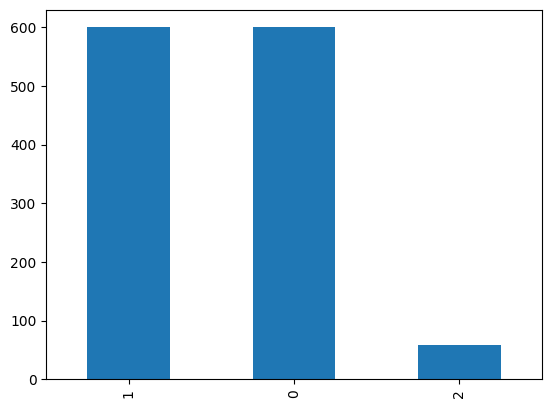

In [ ]:
#악성, 정상 데이터 수 확인 그래프(중복,결측 제거 전)
text_df['target'].value_counts().plot(kind='bar')
text_df['target'].value_counts()

0    1837
1     296
Name: target, dtype: int64

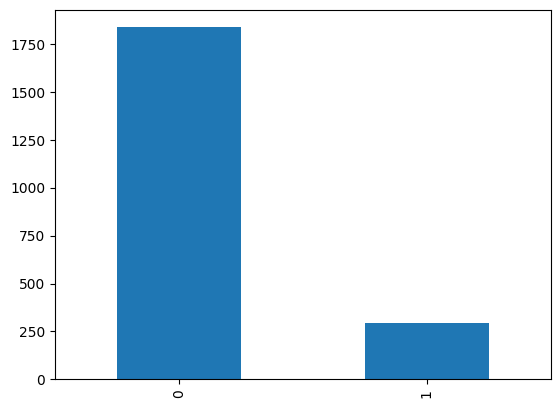

In [ ]:
voice_df['target'].value_counts().plot(kind='bar')
voice_df['target'].value_counts()

In [ ]:
#결측값 확인
text_df.isna().sum()
voice_df.isna().sum()

content    0
target     0
dtype: int64

In [ ]:
#결측값 제거
text_df['content'].dropna(axis=0)
voice_df['content'].dropna(axis=0)

0       1
1       1
2       1
3       1
4       1
       ..
2128    0
2129    0
2130    0
2131    0
2132    0
Name: target, Length: 2133, dtype: int64

In [ ]:
#중복행이 있다면 제거
text_df = text_df.drop_duplicates()
text_df.duplicated().sum()
voice_df = voice_df.drop_duplicates()
voice_df.duplicated().sum()

#제거 후 인덱스 재배열
text_df = text_df.reset_index(drop=True)
voice_df = voice_df.reset_index(drop=True)

0    600
1    541
2     56
Name: target, dtype: int64

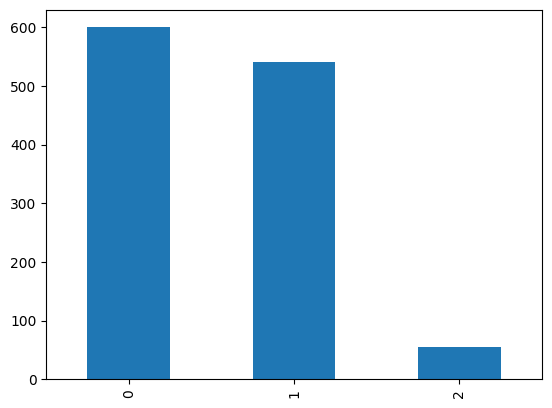

In [ ]:
#악성, 정상 데이터 수 확인 그래프(중복,결측 제거 후)
text_df['target'].value_counts().plot(kind='bar')
text_df['target'].value_counts()

0    1761
1     287
Name: target, dtype: int64

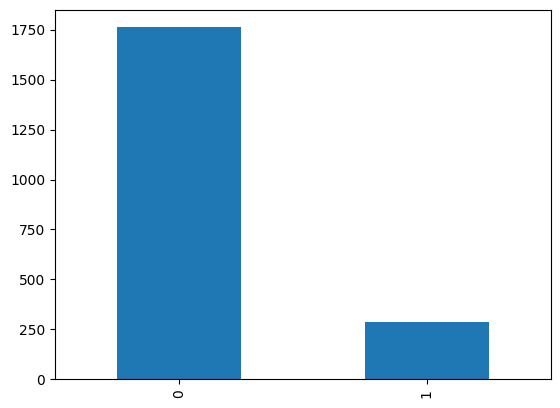

In [ ]:
voice_df['target'].value_counts().plot(kind='bar')
voice_df['target'].value_counts()

In [ ]:
from pykospacing import Spacing
spacing = Spacing()
text_df['content'] = text_df['content'].apply(lambda x:x.replace(" ", ""))

text_df['content'] = text_df['content'].apply(lambda x:spacing(x))
voice_df['content'] = voice_df['content'].apply(lambda x:spacing(x))

KeyboardInterrupt: ignored

In [ ]:
text_df

In [ ]:
voice_df

In [ ]:
text_df['content'] = text_df['content'].apply(lambda x:extract_words(x))
voice_df['content'] = voice_df['content'].apply(lambda x:extract_words(x))

In [ ]:
text_df.isna().sum()
voice_df.isna().sum()

In [ ]:
#전처리 후 spacing으로 빈 데이터 생성되는 것을 확인, 제거용 코드
import numpy as np
text_df['content'].replace(' ', np.nan, inplace=True)
voice_df['content'].replace(' ', np.nan, inplace=True)
text_df = text_df.dropna(axis=0)
voice_df = voice_df.dropna(axis=0)

In [ ]:
text_df.isna().sum()
voice_df.isna().sum()

In [ ]:
# "voice" 토큰 빈도수 계산 - 보이스피싱 전처리가 지속적으로 필요했음.

mal_voice = voice_df[voice_df['target'] == 1]['content'].tolist()
normal_voice = voice_df[voice_df['target'] == 0]['content'].tolist()

from collections import Counter
# 텍스트 데이터를 공백으로 구분하여 하나의 문자열로 결합
mal_voice = ' '.join(mal_voice)
normal_voice = ' '.join(normal_voice)
# 결합된 텍스트를 토큰화하여 토큰 수 계산
m_tokens = mal_voice.split()
n_tokens = normal_voice.split()
# 빈도수 확인
m = Counter(m_tokens)
n = Counter(n_tokens)
# 총 수 확인
n_token_count = len(n_tokens)
p_token_count = len(m_tokens)

# 결과 출력
print("일반 총 토큰 수:", n_token_count)
print("피싱 총 토큰 수:", p_token_count)

In [ ]:
# 상대적 토큰 비율
print(n_token_count / len(n_voice))
print(p_token_count / len(p_voice))

In [ ]:
# n_voice = voice_df[voice_df['target'] == 0]['content'].tolist()
# p_voice = voice_df[voice_df['target'] == 1]['content'].tolist()
# # 텍스트 데이터를 공백으로 구분하여 하나의 문자열로 결합
# n_voice = ' '.join(n_voice)
# p_voice = ' '.join(p_voice)
# # 결합된 텍스트를 토큰화하여 토큰 수 계산
# n_tokens = n_voice.split()
# n_token_count = len(n_tokens)
# p_tokens = p_voice.split()
# p_token_count = len(p_tokens)
# # 결과 출력
# print("일반 총 토큰 수:", n_token_count)
# print("피싱 총 토큰 수:", p_token_count)

In [ ]:
# 보이스피싱 데이터가 너무 길어서 일정 길이로 자르는 코드
# voice_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AI_Hackathon/data/voice_df_f.csv", sep='\t', index_col=0)
# test = voice[voice['target'] == 0]['content'].tolist()
# mal = voice[voice['target'] == 1]['content'].tolist()

# res = []
# tmp = []
# for i in range(len(m_tokens)):
#   tmp.append(m_tokens[i])
#   if(len(tmp)==128):
#     t = (' '.join(tmp))
#     res.append(t)
#     tmp = []

# n_df = pd.DataFrame(res)
# n_df.columns = ['content']
# n_df['target'] = 1

# normal_ = voice_df[voice_df['target'] == 0]
# normal_['content'].replace('', np.nan, inplace=True)
# normal_ = normal_.dropna(axis=0)
# normal_ = normal_.reset_index(drop=True)
# voice_df =  pd.concat([n_df, normal_], ignore_index=True)
# voice_df.to_csv(os.path.join(DATA_PATH,"voice_df_f.csv"), sep='\t', encoding='utf-8')

In [ ]:
# csv file 만들기
text_df.to_csv(os.path.join(DATA_PATH,"text_df_data.csv"), sep='\t', encoding='utf-8')
voice_df.to_csv(os.path.join(DATA_PATH,"voice_df.csv"), sep='\t', encoding='utf-8')

In [ ]:
#빈도수 확인용 코드
from collections import Counter

text_words = " ".join(text_df['content'].tolist())
voice_words = " ".join(voice_df['content'].tolist())

voice_tokens = voice_words.split(" ")

# voice_words = " ".join(voice_df['content'].tolist())

f_text = Counter(text_words).most_common()
f_voice = Counter(voice_tokens).most_common()

In [ ]:
v = Counter(voice_tokens)
v

In [ ]:
#!pip install konlpy
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib.font_manager as fm
sys_font = fm.findSystemFonts()

[f for f in sys_font if 'Nanum' in f]

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumSquareEB.ttf', width=400, height=400, scale=2.0, max_font_size=250)
gen = wc.generate_from_frequencies(m)
plt.figure()
plt.imshow(gen)

In [ ]:
# fc = Counter(one_word)
wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumSquareEB.ttf', width=400, height=400, scale=2.0, max_font_size=250)
gen = wc.generate_from_frequencies(n)
plt.figure()
plt.imshow(gen)

In [ ]:
gen2 = wc.generate_from_frequencies(m)
plt.figure()
plt.imshow(gen2)

In [ ]:
# # 정수인코딩
# train_text = text_df['content'].tolist()

# max_seq_length = max(len(sentence.split()) for sentence in train_text)

In [ ]:
# # Tokenizer를 모든 학습 데이터 문장에 적용합니다.
# # 이 과정에서 학습 데이터에 포함된 모든 token들과 그에 따른 정수 인덱스를 생성합니다.
# import tensorflow as tf
# tokenizer_layer = tf.keras.layers.TextVectorization(
#     output_sequence_length=max_seq_length
# )

# # Tokenizer를 학습합니다.
# tokenizer_layer.adapt(train_text)


In [ ]:
# # Tokenizer를 모든 학습 데이터 문장에 적용합니다.
# # 이 과정에서 학습 데이터에 포함된 모든 token들과 그에 따른 정수 인덱스를 생성합니다.
# tokenizer_model = tf.keras.Sequential([
#     tf.keras.Input(shape=(1,), dtype=tf.string),
#     tokenizer_layer,
# ])
# # 학습 데이터의 각 문장에 토큰화를 수행합니다.
# train_text_seq = tokenizer_model.predict(train_text)

# # Tokenizer가 인식한 전체 토큰 개수를 가져옵니다.
# num_vocab = tokenizer_layer.vocabulary_size()

# print(f"전체 토큰 개수: {num_vocab}개")
# print(
#     f"토큰화 이전: {train_text[0]}\n"
#     f"토큰화 이후: {train_text_seq[0]}"
# )

In [ ]:
# train_text_seq

In [ ]:
# # 임베딩 layer를 생성합니다. 입력 차원은 전체 토큰 개수를, 출력 차원은 원하는 벡터 차원을 지정하면 됩니다.
# embedding_layer = tf.keras.layers.Embedding(
#     input_dim=num_vocab,
#     output_dim=64,
# )

# # 이 또한 layer이기 때문에 모델로 구성해주어야 합니다.
# # 입력값은 각 문장의 길이가 50이므로 50을 지정합니다.
# embedding_model = tf.keras.Sequential([
#     tf.keras.Input(shape=(None,), dtype=tf.int64),
#     embedding_layer
# ])

# # 첫번째 문장의 임베딩 벡터를 생성합니다.
# sample_embedding_vec = embedding_model.predict(train_text_seq[0].reshape(1, -1))

# print(f"임베딩을 수행할 전체 토큰 개수: {num_vocab}")
# print(f"임베딩 결과 벡터의 모양: {sample_embedding_vec.shape}")

In [ ]:
# sample_embedding_vec[0, 0, :]

In [ ]:
# sample_embedding_vec

In [ ]:
import joblib
import numpy as np

# 학습시킨 머신러닝 모델 불러오기 - naive, svc, knn
naive = joblib.load('./naive_model.pkl')
svc = joblib.load('./svc_model.pkl')
knn = joblib.load('./knn_model.pkl')
vector = joblib.load('./tfidf_vector.pkl')

In [ ]:
naive_data = joblib.load('./naive_model_data.pkl')
svc_data = joblib.load('./svc_model_data.pkl')
knn_data = joblib.load('./knn_model_data.pkl')
vector_data = joblib.load('./tfidf_vector_data.pkl')

In [ ]:
#일반 테스트
test0 = "어제 일찍 잠들어서 문자를 못봤네. 무슨 일 있어? 나중에 전화할게. 별일아니야. 밥은 먹었어? 안 먹었으면 꼭 챙겨먹고. 알겠어. 너도"

#스팸 테스트
test1 = '''(광고)[하나은행]100% 드리는 선물![Web발신](광고)[하나은행]김*영님께만 드리는 깜짝 선물!지금 이벤트 페이지에서 참여 완료하시면신라면 큰사발 100% 득템!
◈ 참여 대상 : 본 문자를 하나은행으로부터 수신한 손님
◈ 참여 방법 : 본 문자 내 링크를 통해 이벤트 페이지에서 참여 완료하면 쿠폰 지급 (100% 증정)
◈ 이벤트 기간 : 2023.10.25(수)~10.31(화)
◈ 쿠폰 : CU)농심 신라면 큰사발 교환권 1매
◈ 쿠폰 적립일 : 2023.11.17(금)
※ 앱 푸시로 쿠폰 적립 알림 드려요
※ 쿠폰 확인 : 하나원큐>My하나>쿠폰함

◈ 선물확인하러 가기 : https://hanabank.me/3tGZApH

※ 하나원큐는 하나은행 대표 스마트폰뱅킹 브랜드입니다.
※ 본 이벤트는 은행의 사정에 따라 변경 또는 중단될 수 있으며, 이벤트 혜택은 동일 금액대의 다른 상품으로 변경될 수 있습니다. (단 기조건 충족손님 제외)
※본 이벤트 경품은 교환,환불,환가, 연장 및 재발급이 불가합니다.
※ 쿠폰 사용 관련 유의사항은 발급된 모바일 쿠폰 하단에 명시되어 있습니다.
※ 이벤트 문의는 하나은행 고객센터(1599-1111, 평일 09~18시, 주말/공휴일 제외)로 연락 바랍니다.
※ 본 홍보물은 법령 및 내부통제기준에 따른 절차를 거쳐 제공됩니다.
※ 본 홍보물은 2023년 10월 31일까지 유효합니다.
준법감시인 심의필 제2023-(광고)-06866호(2023.10.06)
무료수신거부 0800901111'''

#스미싱 테스트
test2 = "[Web발신]김서영님 들어오세요 축하드립니다. 내일 오전 급등주 관련 중요소식 알려드립니다. 아직 입장 안하셔서 연락드립니다. 텔레방 입장 부탁드립니다. 무.료.입.장. t.me/tky6789"

In [ ]:
t_script0 = preprocessing(test0)
t_script1 = preprocessing(test1)
t_script2 = preprocessing(test2)

In [ ]:
t_script = [str(t_script0)]
inputdata = vector.transform(t_script)

In [ ]:
# 시연용 코드 - 사용자 입력
def print_result(a, x):
  if a==0:
    print(x,"% 의 확률로 정상입니다.")
  elif a==1:
    print(x,"% 의 확률로 스팸입니다.")
  elif a==2:
    print(x,"% 의 확률로 스미싱입니다.")
  else: print("ERROR")

script = input('판별하고 싶은 문자를 넣어주세요! ->  ')

pre_script = preprocessing(script)
str_script = [str(pre_script)]
inputdata = vector.transform(str_script)

result = []
for model in (naive, svc, knn):
    print("\n")
    print(model.__class__.__name__)
    if model == svc:
      x = svc.decision_function(inputdata)
      probabilities = 1 / (1 + np.exp(-x))
      # print(np.argmax(x))
      y = model.predict(inputdata)
      # print(x)
      # print("predict : ", int(y))
      # print(np.argmax(x))
      re = np.round(probabilities, decimals = 4).flatten()
      print_result(int(y), re[y]*100)

    else:
      x = model.predict_proba(inputdata)
      y = model.predict(inputdata)
      # print(x)
      # print("predict : ", int(y))
      # print(np.argmax(x))
      re = np.round(x, decimals = 5).flatten()
      print_result(int(y), re[y]*100)


In [ ]:
# 사용자 입력 말고 직접 확인용

# def print_result(a, x):
#   if a==0:
#     print(x,"% 의 확률로 정상입니다.")
#   elif a==1:
#     print(x,"% 의 확률로 스팸입니다.")
#   elif a==2:
#     print(x,"% 의 확률로 스미싱입니다.")
#   else: print("ERROR")


# result = []
# for model in (naive, svc, knn):
#     print("\n")
#     print(model.__class__.__name__)
#     if model == svc:
#       x = svc.decision_function(inputdata)
#       probabilities = 1 / (1 + np.exp(-x))
#       # print(np.argmax(x))
#       y = model.predict(inputdata)
#       print(x)
#       print("predict : ", int(y))
#       # print(np.argmax(x))
#       re = np.round(probabilities, decimals = 4).flatten()
#       print_result(int(y), re[y]*100)

#     else:
#       x = model.predict_proba(inputdata)
#       y = model.predict(inputdata)
#       print(x)
#       print("predict : ", int(y))
#       # print(np.argmax(x))
#       re = np.round(x, decimals = 5).flatten()
#       print_result(int(y), re[y]*100)



In [ ]:
# t_scripts = [str(t_script0)]

# inputdatas = vector_f.transform(t_scripts)
# t_scripts

In [ ]:
# def print_result(a, x):
#   if a==0:
#     print(x,"% 의 확률로 정상입니다.")
#   elif a==1:
#     print(x,"% 의 확률로 스팸입니다.")
#   elif a==2:
#     print(x,"% 의 확률로 스미싱입니다.")
#   else: print("ERROR")
# result = []
# for model in (naive_f, svc_f, knn_f):
#     print("\n")
#     print(model.__class__.__name__)
#     if model == svc_f:
#       x = svc.decision_function(inputdatas)
#       # print(np.argmax(x))
#       y = model.predict(inputdatas)
#       print(x)
#       print("predict : ", int(y))
#       # print(np.argmax(x))
#       re = np.round(x, decimals = 4).flatten()
#       print_result(int(y), re[y]*100)

#     else:
#       x = model.predict_proba(inputdatas)
#       y = model.predict(inputdatas)
#       print(x)
#       print("predict : ", int(y))
#       # print(np.argmax(x))
#       re = np.round(x, decimals = 5).flatten()
#       print_result(int(y), re[y]*100)